In [212]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm
from torch.optim import lr_scheduler

In [213]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [214]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [215]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


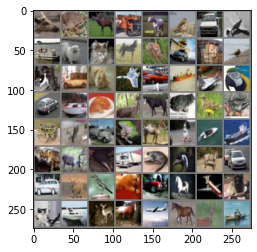

deer  frog  deer  truck horse bird  car   plane ship  dog   cat   horse deer  car   cat   bird  dog   car   cat   plane car   ship  plane bird  car   ship  cat   deer  horse frog  bird  frog  frog  deer  truck frog  horse ship  ship  ship  cat   deer  bird  truck cat   bird  horse car   car   deer  bird  dog   car   horse plane dog   cat   ship  deer  horse plane horse deer  ship 


In [216]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [217]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = self.pool(F.sigmoid(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.sigmoid(self.fc1(x)))
        x = self.dropout(F.sigmoid(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [218]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.01,momentum = 0):
    history = []
    lrs = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    return history, end, lrs

In [219]:
begin = time.time()
history, end, lrs = fit(30, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|██████████| 657/657 [00:10<00:00, 65.40it/s]


Epoch [0], Time taken :11.8631, train_loss : 2.3313, train_acc: 0.0985, val_loss: 2.3216, val_acc: 0.1010


100%|██████████| 657/657 [00:10<00:00, 59.74it/s]


Epoch [1], Time taken :12.8879, train_loss : 2.3186, train_acc: 0.1003, val_loss: 2.3149, val_acc: 0.0943


100%|██████████| 657/657 [00:10<00:00, 63.07it/s]


Epoch [2], Time taken :12.2737, train_loss : 2.3131, train_acc: 0.0977, val_loss: 2.3127, val_acc: 0.0936


100%|██████████| 657/657 [00:10<00:00, 62.17it/s]


Epoch [3], Time taken :12.3374, train_loss : 2.3094, train_acc: 0.1004, val_loss: 2.3083, val_acc: 0.0946


100%|██████████| 657/657 [00:09<00:00, 66.01it/s]


Epoch [4], Time taken :11.7767, train_loss : 2.3078, train_acc: 0.0994, val_loss: 2.3079, val_acc: 0.1014


100%|██████████| 657/657 [00:09<00:00, 65.84it/s]


Epoch [5], Time taken :11.8803, train_loss : 2.3070, train_acc: 0.0989, val_loss: 2.3065, val_acc: 0.0974


100%|██████████| 657/657 [00:10<00:00, 62.99it/s]


Epoch [6], Time taken :12.5298, train_loss : 2.3057, train_acc: 0.1007, val_loss: 2.3043, val_acc: 0.1013


100%|██████████| 657/657 [00:09<00:00, 66.15it/s]


Epoch [7], Time taken :11.8332, train_loss : 2.3057, train_acc: 0.1004, val_loss: 2.3058, val_acc: 0.1019


100%|██████████| 657/657 [00:10<00:00, 64.78it/s]


Epoch [8], Time taken :11.9793, train_loss : 2.3052, train_acc: 0.0981, val_loss: 2.3033, val_acc: 0.0981


100%|██████████| 657/657 [00:10<00:00, 62.34it/s]


Epoch [9], Time taken :12.3313, train_loss : 2.3046, train_acc: 0.0997, val_loss: 2.3048, val_acc: 0.0981


100%|██████████| 657/657 [00:10<00:00, 64.80it/s]


Epoch [10], Time taken :11.9458, train_loss : 2.3042, train_acc: 0.1006, val_loss: 2.3040, val_acc: 0.1020


100%|██████████| 657/657 [00:10<00:00, 65.17it/s]


Epoch [11], Time taken :12.4765, train_loss : 2.3044, train_acc: 0.1010, val_loss: 2.3048, val_acc: 0.1009


100%|██████████| 657/657 [00:09<00:00, 66.16it/s]


Epoch [12], Time taken :11.7165, train_loss : 2.3042, train_acc: 0.1005, val_loss: 2.3045, val_acc: 0.0997


100%|██████████| 657/657 [00:09<00:00, 65.91it/s]


Epoch [13], Time taken :11.8749, train_loss : 2.3042, train_acc: 0.0978, val_loss: 2.3041, val_acc: 0.1070


100%|██████████| 657/657 [00:11<00:00, 59.41it/s]


Epoch [14], Time taken :12.8782, train_loss : 2.3039, train_acc: 0.0994, val_loss: 2.3046, val_acc: 0.0961


100%|██████████| 657/657 [00:10<00:00, 64.95it/s]


Epoch [15], Time taken :12.1601, train_loss : 2.3044, train_acc: 0.0990, val_loss: 2.3041, val_acc: 0.0981


100%|██████████| 657/657 [00:09<00:00, 66.90it/s]


Epoch [16], Time taken :11.9274, train_loss : 2.3040, train_acc: 0.1005, val_loss: 2.3030, val_acc: 0.1040


100%|██████████| 657/657 [00:10<00:00, 62.82it/s]


Epoch [17], Time taken :12.3034, train_loss : 2.3038, train_acc: 0.0996, val_loss: 2.3049, val_acc: 0.0953


100%|██████████| 657/657 [00:10<00:00, 63.61it/s]


Epoch [18], Time taken :12.1162, train_loss : 2.3039, train_acc: 0.0976, val_loss: 2.3043, val_acc: 0.1029


100%|██████████| 657/657 [00:10<00:00, 64.35it/s]


Epoch [19], Time taken :12.0283, train_loss : 2.3041, train_acc: 0.0994, val_loss: 2.3036, val_acc: 0.1076


100%|██████████| 657/657 [00:10<00:00, 62.59it/s]


Epoch [20], Time taken :12.2954, train_loss : 2.3036, train_acc: 0.0976, val_loss: 2.3035, val_acc: 0.0971


100%|██████████| 657/657 [00:10<00:00, 64.51it/s]


Epoch [21], Time taken :11.9590, train_loss : 2.3038, train_acc: 0.0983, val_loss: 2.3038, val_acc: 0.1011


100%|██████████| 657/657 [00:10<00:00, 60.13it/s]


Epoch [22], Time taken :12.7399, train_loss : 2.3034, train_acc: 0.1016, val_loss: 2.3033, val_acc: 0.0926


100%|██████████| 657/657 [00:10<00:00, 65.17it/s]


Epoch [23], Time taken :11.8603, train_loss : 2.3036, train_acc: 0.0986, val_loss: 2.3034, val_acc: 0.1035


100%|██████████| 657/657 [00:10<00:00, 65.18it/s]


Epoch [24], Time taken :12.0457, train_loss : 2.3033, train_acc: 0.1012, val_loss: 2.3034, val_acc: 0.0985


100%|██████████| 657/657 [00:10<00:00, 60.85it/s]


Epoch [25], Time taken :12.7899, train_loss : 2.3036, train_acc: 0.0996, val_loss: 2.3030, val_acc: 0.0996


100%|██████████| 657/657 [00:10<00:00, 65.15it/s]


Epoch [26], Time taken :11.8917, train_loss : 2.3037, train_acc: 0.0985, val_loss: 2.3036, val_acc: 0.0949


100%|██████████| 657/657 [00:09<00:00, 65.94it/s]


Epoch [27], Time taken :11.7831, train_loss : 2.3033, train_acc: 0.1011, val_loss: 2.3035, val_acc: 0.1034


100%|██████████| 657/657 [00:10<00:00, 61.82it/s]


Epoch [28], Time taken :12.4248, train_loss : 2.3032, train_acc: 0.1014, val_loss: 2.3038, val_acc: 0.0927


100%|██████████| 657/657 [00:10<00:00, 65.28it/s]


Epoch [29], Time taken :11.8701, train_loss : 2.3035, train_acc: 0.0999, val_loss: 2.3037, val_acc: 0.0997
Finished Training in 365.23125100135803secs


In [220]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

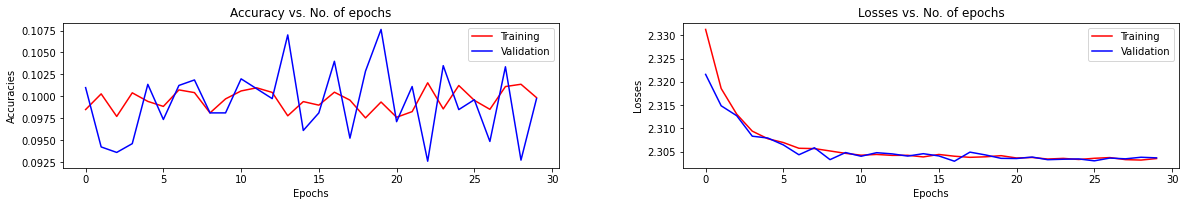

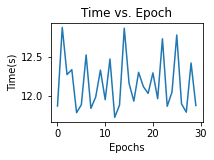

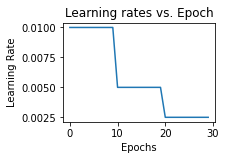

In [221]:
def plot_results(history, lrs):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(221)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(222)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(223)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
    
    plt.subplot(224)
    plt.plot(lrs)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning Rate')
    plt.title('Learning rates vs. Epoch')
    plt.show()
              
plot_results(history, lrs)

In [222]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [223]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [224]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 7.6 %
Accuracy for class: car   is 8.9 %
Accuracy for class: bird  is 5.5 %
Accuracy for class: cat   is 8.7 %
Accuracy for class: deer  is 15.3 %
Accuracy for class: dog   is 14.6 %
Accuracy for class: frog  is 10.2 %
Accuracy for class: horse is 11.1 %
Accuracy for class: ship  is 4.1 %
Accuracy for class: truck is 15.1 %
